<a href="https://colab.research.google.com/github/Rajat-Kumar-Pandey/MACHINE-LEARNING/blob/main/sleep_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random


In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Set paths
data_dir = "/content/drive/MyDrive/datasets"
categories = ["openeyes", "closeeyes"]

# Parameters
img_size = 64
data = []
labels = []

# Load images
for category in categories:
    path = os.path.join(data_dir, category)
    class_label = categories.index(category)  # 0 for 'open_eyes', 1 for 'close_eyes'

    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)  # Grayscale for simplicity
            resized_array = cv2.resize(img_array, (img_size, img_size))  # Resize to img_size
            data.append(resized_array)
            labels.append(class_label)
        except Exception as e:
            print(f"Error loading image {img}: {e}")

# Convert to numpy arrays and normalize
data = np.array(data) / 255.0  # Normalize pixel values to 0-1
labels = np.array(labels)

# Reshape for the model
data = data.reshape(-1, img_size, img_size, 1)  # Add channel dimension


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")


Data shape: (1100, 64, 64, 1)
Labels shape: (1100,)


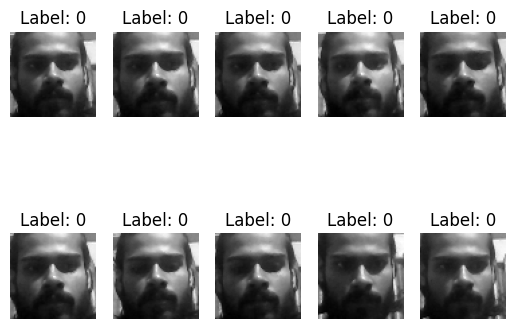

In [4]:
import matplotlib.pyplot as plt

# Display 10 random images from the dataset
for i in range(10):
    plt.subplot(2, 5, i+1)  # Create a grid of 2 rows x 5 columns
    plt.imshow(data[i].reshape(img_size, img_size), cmap='gray')  # Reshape back for visualization
    plt.title(f"Label: {labels[i]}")  # Show label
    plt.axis('off')  # Hide axes
plt.show()


In [5]:
unique, counts = np.unique(labels, return_counts=True)
print(f"Label distribution: {dict(zip(unique, counts))}")


Label distribution: {0: 600, 1: 500}


In [6]:
print(f"Data min: {data.min()}, max: {data.max()}")
print(f"Data mean: {data.mean()}, std: {data.std()}")


Data min: 0.023529411764705882, max: 0.9803921568627451
Data mean: 0.38890074138675373, std: 0.17336156184676688


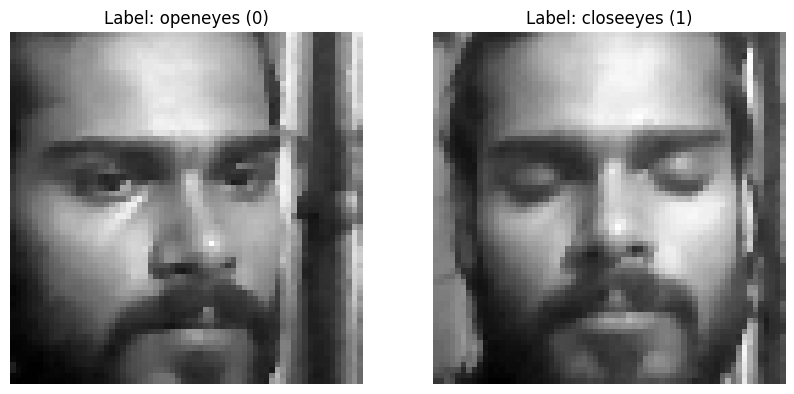

In [7]:


# Function to display random images from both classes
def display_random_images(data, labels, categories, img_size):
    # Select a random index for each category
    openeyes_indices = [i for i, label in enumerate(labels) if label == 0]
    closeeyes_indices = [i for i, label in enumerate(labels) if label == 1]

    random_openeyes_idx = random.choice(openeyes_indices)
    random_closeeyes_idx = random.choice(closeeyes_indices)

    # Plot the images
    plt.figure(figsize=(10, 5))

    # Openeyes image
    plt.subplot(1, 2, 1)
    plt.imshow(data[random_openeyes_idx].reshape(img_size, img_size), cmap='gray')
    plt.title(f"Label: {categories[0]} (0)")
    plt.axis('off')

    # Closeeyes image
    plt.subplot(1, 2, 2)
    plt.imshow(data[random_closeeyes_idx].reshape(img_size, img_size), cmap='gray')
    plt.title(f"Label: {categories[1]} (1)")
    plt.axis('off')

    plt.show()

# Call the function
display_random_images(data, labels, categories, img_size)

In [8]:
validation_data, train_data, validation_labels, train_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

In [9]:
from tensorflow.keras.optimizers import Adam
# Sequential model function
def create_enhanced_model(input_shape):
    """
    Build a Sequential model with additional layers for improved accuracy.
    """
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),

        # Fully connected layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model
    optimizer = Adam(learning_rate=0.00001)  # Adjust the learning rate
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [10]:
# Define input shape (grayscale images, e.g., 64x64)
input_shape = (img_size, img_size, 1)  # Replace `img_size` with your image dimensions

# Create both models
enhanced_model = create_enhanced_model(input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
print("Enhanced Model Summary:")
enhanced_model.summary()


Enhanced Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,649 (2.61 MB)

 Trainable params: 683,201 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
# Data Augmentation Function
def augment_data(X_train, y_train):
    """
    Use data augmentation to artificially expand the training dataset.
    """
    # Initialize the ImageDataGenerator with augmentations
    datagen = ImageDataGenerator(
        rotation_range=10,          # Rotate images randomly by 10 degrees
        width_shift_range=0.1,      # Shift images horizontally by 10%
        height_shift_range=0.1,     # Shift images vertically by 10%
        shear_range=0.1,            # Shear transformation by 10%
        zoom_range=0.1,             # Zoom in/out by 10%
        horizontal_flip=True,       # Randomly flip images horizontally
        fill_mode='nearest'         # Fill any missing pixels after transformation
    )

    # Fit the generator to the training data
    datagen.fit(X_train)

    return datagen

In [13]:

# Create the data generator
train_datagen = augment_data(train_data, train_labels)


In [14]:
# Create the train_generator to feed into the model during training
train_generator = train_datagen.flow(
    train_data, train_labels,
    batch_size=32,  # Adjust batch size as needed
    shuffle=True     # Shuffle the data for better randomness
)

In [15]:
validation_datagen = ImageDataGenerator(rescale=1./255)  # Rescaling only for validation data
validation_generator = validation_datagen.flow(
    validation_data, validation_labels,
    batch_size=32,
    shuffle=False   # No shuffling for validation data
)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Define EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=10,              # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the model with the best weights
)
# Define ModelCheckpoint Callback
model_checkpoint = ModelCheckpoint(
    'best_model.keras',      # Change the file extension to .keras
    monitor='val_loss',      # Monitor the validation loss
    save_best_only=True,     # Only save the best model
    save_weights_only=False, # Save the full model (including architecture)
    mode='min',              # Minimize validation loss
    verbose=1                # Show messages when saving the model
)



In [17]:
# from tensorflow.keras import regularizers
enhanced_model.add(Dense(1, activation='sigmoid'))  # 1 output unit for binary classification



In [18]:
 #Train the model using the generators
history = enhanced_model.fit(
    train_generator,
    steps_per_epoch=train_data.shape[0] // 32,  # Adjust based on dataset size
    epochs=20,  # Set the number of epochs you wish to train for
    validation_data=validation_generator,
    validation_steps=validation_data.shape[0] // 32,  # Adjust for validation data
    callbacks=[early_stopping, model_checkpoint]  # Use callbacks to stop early and save the best model
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.5506 - loss: 0.7896
Epoch 1: val_loss improved from inf to 0.72933, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 639ms/step - accuracy: 0.5510 - loss: 0.7874 - val_accuracy: 0.5359 - val_loss: 0.7293
Epoch 2/20
1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.7188 - loss: 0.6359
Epoch 2: val_loss improved from 0.72933 to 0.71075, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7188 - loss: 0.6359 - val_accuracy: 0.5625 - val_loss: 0.7108
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.5741 - loss: 0.7425
Epoch 3: val_loss did not improve from 0.71075
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 671ms/step - accuracy: 0.5719 - loss: 0.7414 - val_accuracy: 0.5359 - val_loss: 0.7322
Epoch 4/20
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.7188 - loss: 0.6228
Epoch 4: val_loss did not improve from 0.71075
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - accuracy: 0.7188 - loss: 0.6228 - val_accuracy: 0.5625 - val_loss: 0.7132
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.5456 - loss: 0.7661
Epoch 5: val_loss did not improve from 0.71075
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 587ms/step - accuracy: 0.5520 - loss: 0.7610 - val_accuracy: 0.5359 - val_loss: 0.7357
Epoch 6/20
1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.5312 - loss: 0.7941
Epoch 6: val_loss did not improve from 0.71075
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5312 - loss: 0.7941 - val_accuracy: 0.5625 - val_loss: 0.7160
Epoch 7/20
6/6 ━━━━━━━━━━━━━

In [19]:
enhanced_model.save("drowsiness_detection_model.h5")
